In [1]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os
import numpy as np

cluster = SLURMCluster(
    cores=1,
    processes=1,
    memory="10GB",
    #n_workers=300,
    shebang='#!/usr/bin/env bash',
    queue="irb_slurm",
    walltime="00:30:00",
    log_directory="/mnt/beegfs/scratch/slurm_log/",
    scheduler_options={'port': 6818, 'host':'192.168.200.112'}, 
    # local_directory='/mnt/beegfs/scratch/tmp',
    death_timeout="15s",
    # interface="bond0",
    # log_directory=f'{os.environ["SCRATCH_cecam"]}/{os.environ["USER"]}/dask_jobqueue_logs/',
    # project="ecam"
)

In [36]:
import dask.distributed
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os
import numpy as np

from dask import config
# dask.config.config['jobqueue']['slurm']

# config = dask.config.get('jobqueue.slurm')
cluster = SLURMCluster(config_name = 'slurm')

In [2]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/beegfs/scratch/slurm_log//dask-worker-%J.err
#SBATCH -o /mnt/beegfs/scratch/slurm_log//dask-worker-%J.out
#SBATCH -p irb_slurm
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 00:30:00

/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/bin/python -m distributed.cli.dask_worker tcp://192.168.200.100:6818 --name dummy-name --nthreads 1 --memory-limit 9.31GiB --nanny --death-timeout 15s



In [40]:
client = Client(cluster)
cluster.scale(150)
cluster.wait_for_workers(150)

In [3]:
client = Client(cluster)
cluster.scale(250)
cluster.wait_for_workers(250)

In [4]:
cluster

SLURMCluster(60b45232, 'tcp://192.168.200.100:6818', workers=250, threads=250, memory=2.27 TiB)

In [5]:
client

<Client: 'tcp://192.168.200.100:6818' processes=250 threads=250, memory=2.27 TiB>

In [6]:
cluster.dashboard_link

'http://192.168.200.100:8787/status'

In [7]:
client.dump_cluster_state

<bound method Client.dump_cluster_state of <Client: 'tcp://192.168.200.100:6818' processes=250 threads=250, memory=2.27 TiB>>

In [18]:
client.shutdown()

In [19]:
cluster.close()

In [12]:
# import hipscat_import.pipeline as runner
from hipscat_import.pipeline import pipeline_with_client
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.catalog.file_readers import ParquetReader
import glob

in_file_paths = glob.glob("outputs/trilegal-*.parquet")
print(f"Input files: {len(in_file_paths)}")
#in_file_paths = glob.glob("outputs/trilegal-00000*.parquet")
in_file_paths.sort()
args = ImportArguments(
    output_artifact_name="trilegal",
    output_path="/home/lovro/scratch/data/TRILEGAL_hipscat_cluster",
    input_file_list=in_file_paths,
    file_reader=ParquetReader(),
    ra_column="ra",
    dec_column="dec",
    highest_healpix_order=9,
    overwrite=True,
    catalog_type="object",
    sort_columns="ra",
    dask_n_workers=250,
    # dask_tmp="/nvme/tmp/dask_tmp",
    # tmp_dir="/nvme/tmp/tmp_dir",
    # resume="/nvme/tmp/resume_tmp",
    pixel_threshold=5_000_000
)
# runner.pipeline(args)
with client:
    pipeline_with_client(args, client)

Input files: 697


Planning  :   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'scatter'

In [12]:
# import hipscat_import.pipeline as runner
from hipscat_import.pipeline import pipeline_with_client
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.catalog.file_readers import ParquetReader
import glob

in_file_paths = glob.glob("outputs/trilegal-*.parquet")
print(f"Input files: {len(in_file_paths)}")
#in_file_paths = glob.glob("outputs/trilegal-00000*.parquet")
in_file_paths.sort()
args = ImportArguments(
    output_artifact_name="trilegal",
    output_path="trilegal",
    input_file_list=in_file_paths,
    file_reader=ParquetReader(),
    ra_column="ra",
    dec_column="dec",
    highest_healpix_order=10,
    overwrite=True,
    catalog_type="object",
    sort_columns="ra",
    dask_n_workers=100,
    # dask_tmp="/nvme/tmp/dask_tmp",
    # tmp_dir="/nvme/tmp/tmp_dir",
    # resume="/nvme/tmp/resume_tmp",
    pixel_threshold=5_000_000
)
# runner.pipeline(args)
with client:
    pipeline_with_client(args, client)

/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input files: 607


Finishing : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.92s/it]


In [16]:
import lsdb

trilFn = "/mnt/beegfs/scratch/photod/trilegal/trilegal/"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec'])
# tril.plot_pixels()
# h = tril.skymap_histogram(lambda df, a: len(df), order=9) -- ta funkcija ne postoji?

In [22]:
# tril.query("dec>45").compute()

,ra,dec
_hipscat_index,,


In [36]:
h = tril.skymap(lambda df, a: len(df), order=9)

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

Stragglers!

In [23]:
%%time
# with client:
h = tril.skymap_histogram(lambda df, a: np.log(len(df)+1), order=9)

CPU times: user 4min 11s, sys: 12.6 s, total: 4min 24s
Wall time: 10min 59s


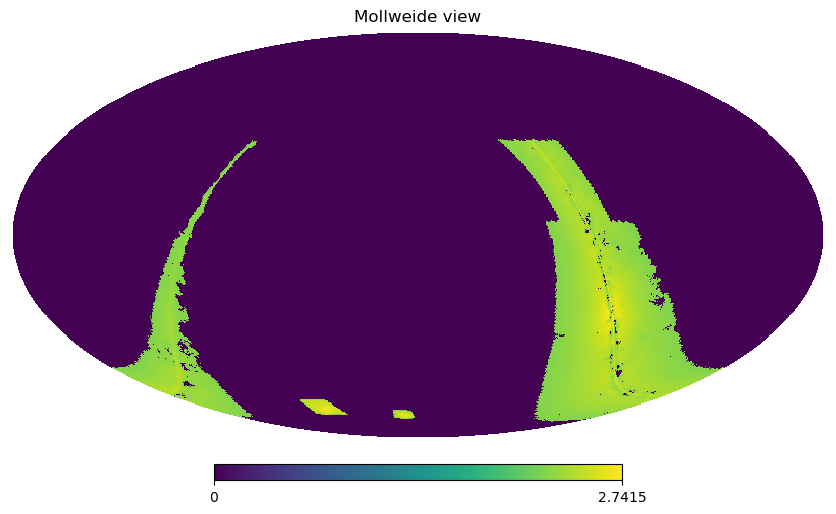

In [24]:
import healpy as hp


NSIDE=2**9

def skymap_aux(fn):
    df = pd.read_parquet(fn, columns='ra dec'.split())
    ipix = hp.ang2pix(NSIDE, df["ra"], df["dec"], nest=True, lonlat=True)
    i, ct = np.unique(ipix, return_counts=True)
    return i, ct

img = np.zeros(hp.nside2npix(NSIDE), dtype=int)

hp.mollview(np.log(h+1), nest=True, cbar=True)

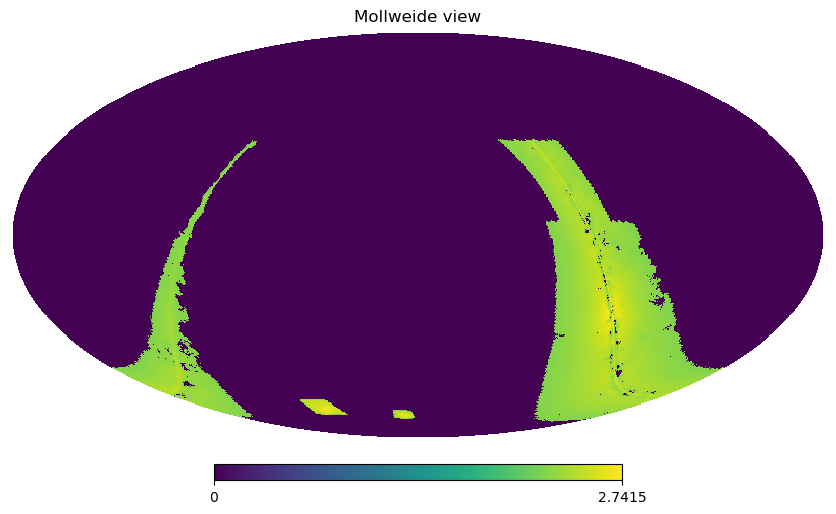

In [25]:
hp.mollview(np.log(h+1), nest=True)

In [17]:
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

def calc_Mr(df):
    # TODO: calculate absmag in the r band based on logl, logg, etc...
    # and return it. This will be stored as a new column named 'Mr'
    # (because of the tril.assign call further below).
    return df["m_ini"] * 3.14

def calc_r(df):
    # TODO: calculate apparent magnitude from absolute + distance
    return df["Mr"] + 5

def calc_g(df):
    # TODO: calculate gr color from logl, logg, etc., then g-band magnitude
    gr = 2
    return df["r"] + gr

# trilFn = "catalogs/trilegal-flip"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec', 'm_ini']) #, search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=10*3600))
tril = tril.assign(Mr = calc_Mr, r = calc_r, g = calc_g)
tril.to_hipscat("foo", overwrite=True)

In [30]:
ls foo

 catalog_info.json  'Norder=1'/  'Norder=5'/  'Norder=9'/
 _common_metadata   'Norder=2'/  'Norder=6'/   partition_info.csv
 _metadata          'Norder=3'/  'Norder=7'/   provenance_info.json
'Norder=0'/         'Norder=4'/  'Norder=8'/


In [32]:
_ = lsdb.read_hipscat("foo")

In [ ]:
_.compute()